In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# First row from the measurement table
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fdef801c6d0>,
 'id': 1,
 'prcp': 0.08,
 'tobs': 65.0,
 'station': 'USC00519397',
 'date': '2010-01-01'}

In [10]:
# First row from the station table
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fdf29651400>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397',
 'id': 1,
 'latitude': 21.2716,
 'elevation': 3.0}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
earliest_date =  session.query(Measurement.date).order_by(Measurement.date).first()
earliest_date

('2010-01-01',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date= session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latestdate = dt.datetime.strptime(latest_date[0], '%Y-%m-%d')
query_date_year_ago = dt.date(latestdate.year -1, latestdate.month, latestdate.day)

# Perform a query to retrieve the data and precipitation scores
prep_selection = [Measurement.date,Measurement.prcp]
query_result = session.query(*prep_selection).filter(Measurement.date >= query_date_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(query_result, columns=['Date','Precipitation'])
precipitation_df = precipitation_df.dropna(how='any')

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(["Date"], ascending=True)
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15


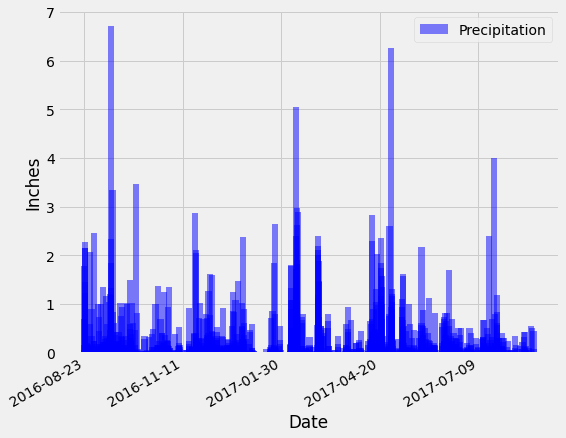

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
# get the axis in a variable
x_axis = precipitation_df.index.tolist()
y_axis = precipitation_df['Precipitation'].tolist()

# plot bar chat
plt.figure(figsize=(8,7))
plt.bar(x_axis,y_axis,width = 5 ,color='blue', alpha=0.5, align="center",label='Precipitation')

ticks = np.arange(0,400,80)
plt.xticks(ticks)

plt.xlabel("Date")
plt.ylabel("Inches")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
# Save Figure
plt.savefig("Precipitation_Plot.png")
# show plot
plt.gcf().autofmt_xdate()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stat_selection = [Measurement.station,func.count(Measurement.id)]
active_stations = session.query(*stat_selection).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest,
# highest, and average temperature.
selection = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_act_station = session.query(*selection).group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).first()
most_act_station

(54.0, 85.0, 71.66378066378067)

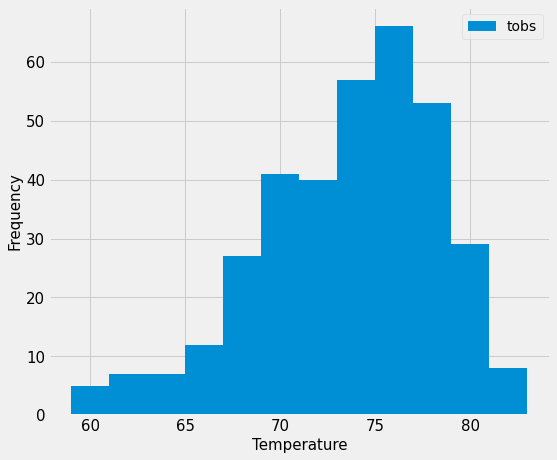

<Figure size 432x288 with 0 Axes>

In [18]:
# Choose the station with the highest number of temperature observations.
session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first() # 'USC00519281'
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.tobs).\
            filter(Measurement.date.between(query_date_year_ago,latestdate),\
                   Measurement.station == 'USC00519281').all()

# Plot the results as a histogram
plt.figure(figsize=(8,7))
plt.hist(np.ravel(results), bins=12)

plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=15)
plt.xticks(size=15)

# Save Figure
plt.savefig("station_Plot.png")
# Show plot
plt.show()
plt.tight_layout()

# Close session

In [46]:
# Close Session
session.close()

## Part 2: Design Your Climate App 
Available in app.py file